# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

disable deprecated pandas warning

In [2]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

Default variable

In [3]:
DEFAULT_EXPLANATION_PERIOD = 30
DEFAULT_IN_SAMPLE_MONTH = 1
DEFAULT_HALF_LIFE = 3600

DEFAULT_STOCK = "AAPL"
DEFAUL_DATE = "2019-02-14"

# Data pipeline

## Base data import

We create function to import the bin and fill data (by sampling many CSV files)

In [4]:
def import_data(path="data_lobster/binSamples",file_limit = None,columns = ["date","time","stock","trade","mid"]):
    columns = columns + ["date"] if "date" not in columns else columns
    data = pd.DataFrame(columns=columns)
    file_limit = len(os.listdir(path=path)) if file_limit is None else min(len(os.listdir(path=path)),file_limit)
    for index,csv_file in enumerate(os.listdir(path=path)[:file_limit]):
        print(f"Reading file : {index+1} out of {file_limit} ...",end="\r")
        df = pd.read_csv(f"{path}/{csv_file}")[columns]
        data = pd.concat([data,df])
    data["date"] = pd.to_datetime(data["date"])
    data = data.drop_duplicates()
    print(f"Done reading file.                      ",end="\r")
    return data

In [5]:
if "bin_sample_all_file.csv" not in os.listdir("data_lobster/refined_data/") : 
    bin_sample_df = import_data(path="data_lobster/binSamples",file_limit = 6)
    bin_sample_df.to_csv("data_lobster/refined_data/bin_sample_all_file.csv",index=False)
else:
    bin_sample_df = pd.read_csv("data_lobster/refined_data/bin_sample_all_file.csv")
    bin_sample_df["date"] = pd.to_datetime(bin_sample_df["date"])

In [6]:
# if "fill_sample_all_file.csv" not in os.listdir("data_lobster/refined_data/") : 
#     fill_sample_df = import_data(path="data_lobster/fillSamples",file_limit = None)
#     fill_sample_df.to_csv("data_lobster/refined_data/fill_sample_all_file.csv",index=False)
# else:
#     fill_sample_df = pd.read_csv("data_lobster/refined_data/fill_sample_all_file.csv")
#     fill_sample_df["date"] = pd.to_datetime(fill_sample_df["date"])

## Volume curves

In [7]:
def pivot_trade_px_df(trade_df : pd.DataFrame)->pd.DataFrame:
    return trade_df[["stock", "date", "mid", "time"]].pivot(index=["stock", "date"], columns=["time"])["mid"].fillna(method="ffill", axis="columns").fillna(method="bfill", axis="columns")

In [8]:
def pivot_trade_volume_df(trade_df:pd.DataFrame)->pd.DataFrame:
    return trade_df[["stock", "date", "trade","time"]].pivot(index=["stock", "date"],columns=["time"])["trade"].fillna(0).astype(int)

In [9]:
def get_volume_curve_df(bin_sample_data:pd.DataFrame,date = None)->pd.DataFrame :
    if date is not None:
        #If date is not None => Need to truncate the input dataframe to the last month before the provided date
        #Else, assume it's already been done
        bin_sample_data = bin_sample_data[(date - bin_sample_data["date"]<=datetime.timedelta(days = 31)) & (date - bin_sample_data["date"] >= datetime.timedelta(days=0))]
    traded_volume_df = pivot_trade_volume_df(bin_sample_data)
    unsigned_traded_volume_df = traded_volume_df.abs().reset_index()
    volume_curve_df = unsigned_traded_volume_df.groupby(["stock"]).mean()
    volume_curve_df.iloc[:,:] = volume_curve_df.values[:,::-1].cumsum(axis=1)[:,::-1] 
    return volume_curve_df

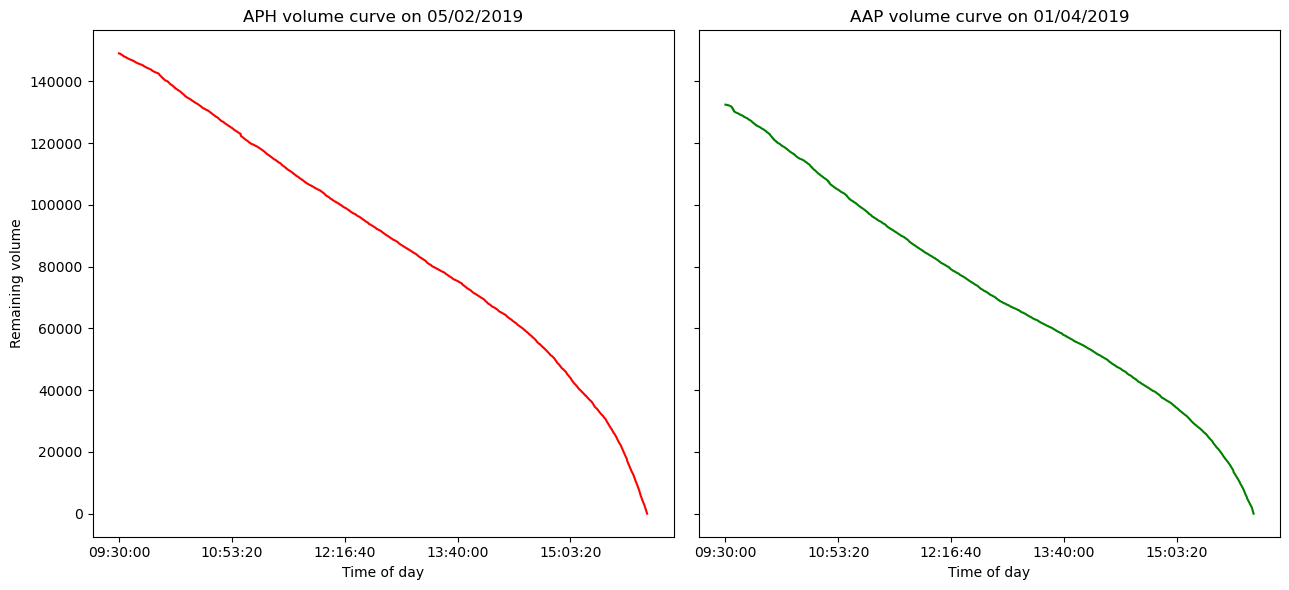

In [10]:
stock_date_pairs = [("APH",datetime.datetime(year = 2019,day = 5, month = 2),"red"),("AAP",datetime.datetime(year = 2019,day = 1, month = 4),"green")]

fig,axs = plt.subplots(1,2,figsize = (13,6),sharey=True)
for index,(stock,date,color) in enumerate(stock_date_pairs):
    ax = axs[index]
    monthly_volume_curve_df = get_volume_curve_df(bin_sample_data=bin_sample_df,date = date)
    monthly_volume_curve_df.loc[stock,:].T.plot(ax = ax,color=color)
    ax.set_title(f"{stock} volume curve on {date.strftime(format='%d/%m/%Y')}")
    if index <len(stock_date_pairs)-1:
        ax.set_ylabel("Remaining volume")
    ax.set_xlabel("Time of day")
plt.tight_layout()
plt.show()

We compute the volume curve for all the stocks for the entire year-worth of data

In [11]:
volume_curve_df = get_volume_curve_df(bin_sample_df,date=None)
# volume_curve_df.to_csv("data_lobster/refined_data/volume_curve_df_all_year.csv",index=False)

# Pratical example : VWAP schedules

In [12]:
def VWAP_naive(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    Q : target volume trade

    qt (naive) = abs(vt) / sigma_s(abs(vs)) * Q
    """
    sigma_v = np.abs(v).sum()
    q = np.abs(v)/sigma_v * Q
    return q

def VWAP_slippage(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    Q : target volume trade

    qt (slippage) = abs( v(t-dt) ) / sigma_s(abs(vs)) * Q
    """
    rolled_v =  np.roll(v, 1)
    rolled_v[0] = 0
    sigma_v = np.abs(rolled_v).sum()
    q = np.abs(rolled_v)/sigma_v * Q
    return q


def VWAP_realistic(v : np.ndarray,Q : float,V : np.ndarray = None) -> np.ndarray:
    """
    v : volume traded at each time interval t (starts from 9:00 to 16:00 with one datapoint every 10sec)
    V : average traded volume at each time interval t
    Q : target volume trade
    """
    n = len(v)
    q_realistic = np.zeros_like(v)

    abs_v_rolled = np.abs(np.roll(v, 1))
    abs_v_rolled[0] = 0

    q_realistic[0] = np.minimum(abs_v_rolled[0] / V[0] * Q, Q)

    for t in range(1, n):
        q_cumulative = q_realistic[:t].sum()
        q_remaining = np.maximum(Q - q_cumulative, 0)
        q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)

    return q_realistic


def TWAP(v : np.ndarray, Q : float , V : np.ndarray = None) ->np.ndarray:
    """
    TWAP executes a an equal % of Q at each time step to completion (100 time steps => 0.1*Q order sent at each time step)
    """
    n = len(v)
    q = np.ones_like(v) * Q / n
    return q

C:\Users\Dedie\AppData\Local\Temp\ipykernel_4864\1931670902.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)
C:\Users\Dedie\AppData\Local\Temp\ipykernel_4864\1931670902.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)
C:\Users\Dedie\AppData\Local\Temp\ipykernel_4864\1931670902.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)
C:\Users\Dedie\AppData\Local\Temp\ipykernel_4864\1931670902.py:43: RuntimeWarning: divide by zero encountered in true_divide
  q_realistic[t] = np.minimum(abs_v_rolled[t] / V[t] * Q, q_remaining)


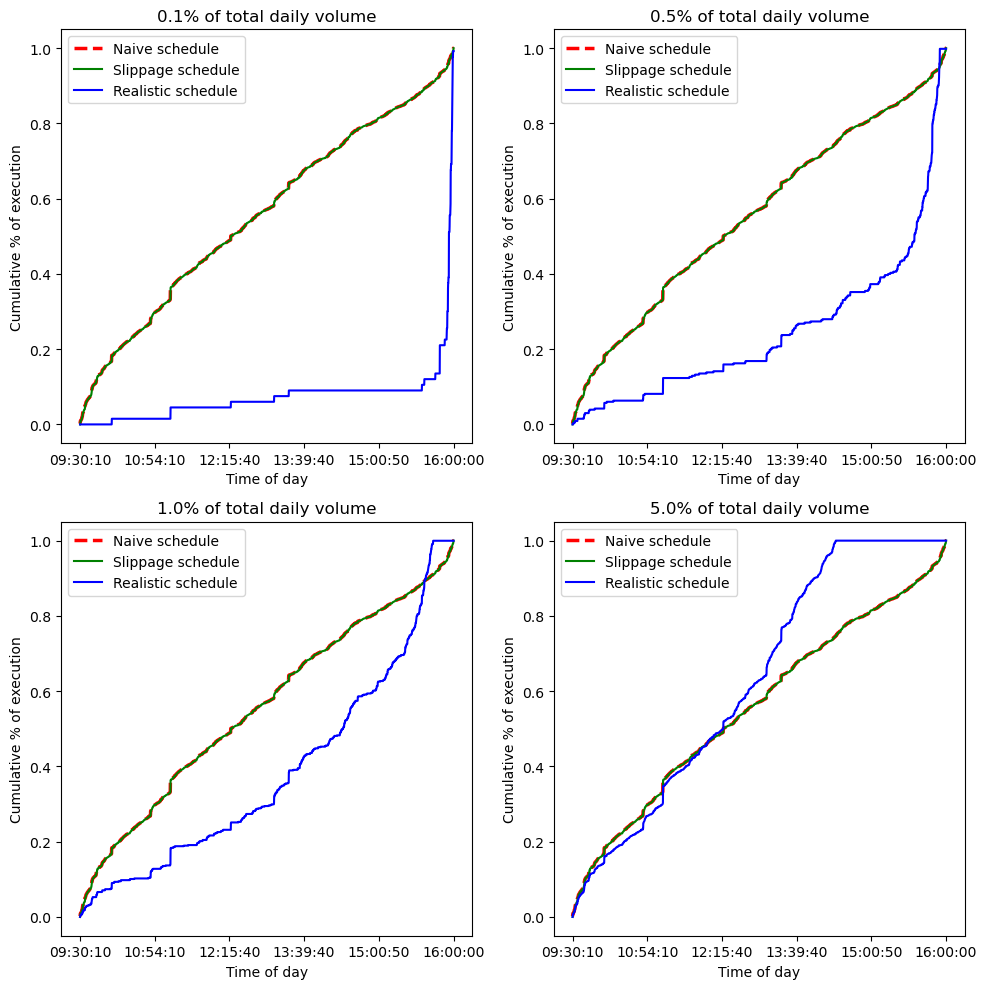

In [13]:
date = datetime.datetime(day = 5,month = 2,year = 2019)
stock = "AAPL"

v = pivot_trade_volume_df(bin_sample_df)
V = get_volume_curve_df(bin_sample_data=bin_sample_df,date=date)


v = v.loc[stock].loc[date].values
V = V.loc[stock].values
Q_pcts = [0.001,0.005,0.01,0.05]

fig,axs = plt.subplots(2,2,figsize = (10,10))
x_values = bin_sample_df["time"].unique()
for index,Q_pct in enumerate(Q_pcts):
    q1 = VWAP_naive(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())
    q2 = VWAP_slippage(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())
    q3 = VWAP_realistic(v=v,V = V,Q = Q_pct * v.sum()).cumsum() / (Q_pct * v.sum())

    ax = axs[index//2][index%2]

    ax.plot(x_values,q1,color="red",label="Naive schedule" ,linestyle = "dashed",linewidth=2.5)
    ax.plot(x_values,q2,color="green",label="Slippage schedule")
    ax.plot(x_values,q3,color="blue",label="Realistic schedule")

    step = len(ax.get_xticks()) // 5
    ax.set_xticks(ax.get_xticks()[::step])

    ax.set_title(f"{Q_pct * 100:.1f}% of total daily volume")
    ax.legend()

    ax.set_xlabel("Time of day")
    ax.set_ylabel("Cumulative % of execution")
plt.tight_layout()
# fig.suptitle(f"Different VWAP schedule for different percentage of total volume of {stock} on {date.strftime('%d/%m/%Y')}", fontsize=16)
plt.show()

# Price impact models

### Computing average daily volume and volatility

In [14]:
def compute_average_daily_volume_and_vol(bin_sample_data:pd.DataFrame) -> pd.DataFrame : 
    adv_ret = bin_sample_data[["stock", "date", "mid","time"]].pivot(index=["stock", "date"],columns=["time"])["mid"]
    adv_ret = adv_ret.fillna(method="bfill",axis=1).fillna(method="ffill",axis=1)
    adv_ret.iloc[:,:] = (adv_ret.iloc[:,:]-np.roll(adv_ret.iloc[:,:],1,axis=1)) / adv_ret.iloc[:,:]
    adv_ret.iloc[:,0] = 0.
    adv_ret["px_vol"] = adv_ret.std(axis=1)
    adv_ret = adv_ret["px_vol"]
    adv_vol = bin_sample_df[["stock", "date","trade"]]
    adv_vol = adv_vol.assign(trade= adv_vol["trade"].abs() )
    adv_vol = adv_vol.groupby(["stock","date"]).agg({"trade":"sum"}).rename(columns= {"trade":"volume"})
    adv_vol = adv_vol.assign(px_vol=adv_ret)
    return adv_vol

def compute_average_rolling_volume_and_vol(adv:pd.DataFrame,window_days = 20) ->pd.DataFrame:
    adv_vol_rolling_mean = adv.rolling(window=window_days).mean().shift(1).dropna()
    return adv_vol_rolling_mean

In [15]:
adv_vol = compute_average_daily_volume_and_vol(bin_sample_df)
adv_vol_rolling_mean = compute_average_rolling_volume_and_vol(adv_vol)

In [16]:
bin_traded_volume = pivot_trade_volume_df(bin_sample_df)
bin_traded_px = pivot_trade_px_df(bin_sample_df)

In [68]:
class PriceImpactModel:

    def __init__(self,bin_sample_data:pd.DataFrame,average_daily_volume_vol:pd.DataFrame = None,bin_traded_volume:pd.DataFrame = None,bin_traded_px :pd.DataFrame = None):

        self.__bin_sample_data = bin_sample_data
        self.__average_daily_volume_vol = average_daily_volume_vol if average_daily_volume_vol is not None else compute_average_daily_volume_and_vol(bin_sample_data)
        self.__average_rolling_volume_vol = compute_average_rolling_volume_and_vol(self.__average_daily_volume_vol)
        self.__bin_traded_volume = bin_traded_volume if bin_traded_volume is not None else pivot_trade_volume_df(bin_sample_data)
        self.__bin_traded_px = bin_traded_px if bin_traded_px is not None else pivot_trade_px_df(bin_sample_data)

        #Database of previously computed computationnal-heavy dataframe
        self.__cum_impact_data = dict()
        self.__regression_result_data = dict()
        self.__no_impact_prices_data = dict()

        self.time_unit = 10 #One data point every 10 seconds

        self.__average_daily_volume_vol = self.__average_daily_volume_vol.astype(np.float64)
        self.__average_rolling_volume_vol = self.__average_rolling_volume_vol.astype(np.float64)
        self.__bin_traded_volume = self.__bin_traded_volume.astype(np.float64)
        self.__bin_traded_px = self.__bin_traded_px.astype(np.float64)

        self.__impact_coef_one_df = pd.DataFrame(index = self.__average_daily_volume_vol.index ,columns= ["impact_coef"],dtype=np.float32) #all ones dataframe index is multilevel "stock > date"
        self.__impact_coef_one_df.iloc[:] = 1.
    
    def get_bin_traded_px(self):
        return self.__bin_traded_px  
    
    def get_volume_curve_from_data(self,date = None):
        return get_volume_curve_df(bin_sample_data=self.__bin_sample_data,date = date)

    def get_bin_traded_volume(self):
        return self.__bin_traded_volume
    
    def impact_state(self, half_life, model_type):
        # model_type can be any of linear, sqrt, afs or reduced_form
        space_kernels = {
            "linear": lambda x: x,
            "sqrt": lambda x: np.sign(x) * np.sqrt(np.abs(x)),
        }
        mtype = model_type
        if model_type == "afs" or model_type == "reduced_form":
            model_type = "linear"

        beta = np.log(2) / half_life
        decay_factor = np.exp(-beta * self.time_unit)
        pre_ewm = self.__bin_traded_volume.copy()

        if mtype == "reduced_form":
            hf_volumes = self.volumes.abs().groupby(level = "date").apply(lambda x: x.ewm(alpha=1-decay_factor, adjust=False, axis = "rows").mean())
            pre_ewm = pre_ewm.divide(np.sqrt(self.__average_daily_volume_vol["volume"]*hf_volumes),axis="rows")
            print("here")
        else:
            pre_ewm = pre_ewm.divide(self.__average_daily_volume_vol["volume"],axis="rows")

        # Q / ADV
        pre_ewm = space_kernels[model_type](pre_ewm)
        pre_ewm = pre_ewm.multiply(self.__average_daily_volume_vol["px_vol"],axis="rows")
        pre_ewm.iloc[:,1:] /= (1 - decay_factor)
        cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis = "columns").mean()
        
        if model_type == "afs":
            cum_impact = space_kernels["sqrt"](cum_impact)

        return cum_impact
    
    def compute_and_store_impact(self,model_type : str,half_life : float , impact_coef_lambda : pd.DataFrame = None,trades : pd.DataFrame = None) -> pd.DataFrame:
        """
        Compute the impact pivoted dataframe with a model type and its relevant half life
        """
        if model_type in ["linear","sqrt"]:
            # space kernels
            space_kernels = {
                "linear" : lambda x : x,
                "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
            }
            trades = trades if trades is not None else self.__bin_traded_volume
            impact_coef_lambda = impact_coef_lambda if impact_coef_lambda is not None else self.__impact_coef_one_df
            beta = np.log(2) / half_life # we know that half-life = ln(2)/Beta
            decay_factor = np.exp(-beta * self.time_unit )
            pre_ewm = trades.copy()
            pre_ewm = pre_ewm.divide(self.__average_daily_volume_vol["volume"], axis="rows") 
            alpha = 1-decay_factor
            pre_ewm = space_kernels[model_type](pre_ewm)
                        
            pre_ewm = pre_ewm.multiply(self.__average_daily_volume_vol["px_vol"], axis="rows")
            pre_ewm = pre_ewm.multiply(impact_coef_lambda["impact_coef"],axis = "rows")
            pre_ewm.iloc[:, 1:] /= alpha
            cum_impact = pre_ewm.ewm(alpha=alpha, adjust=False, axis="columns").mean()
            cum_impact = cum_impact.dropna()
            self.__cum_impact_data[(model_type,half_life)] = cum_impact
            return cum_impact
        else:
            raise Exception("Argument Error : model type must be one of 'linear','sqrt'")
        
    def get_cum_impact_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__cum_impact_data.get(key)

    def get_regression_result_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__regression_result_data.get(key)
    
    def get_no_impact_price_by_key(self,key : tuple) -> pd.DataFrame:
        return self.__no_impact_prices_data.get(key)
    
    def get_impact_coef_stock(self,stock):
        res = []
        for key,val in self.__regression_result_data.items():
            res.append((key,val.loc[stock,"beta_estimate"]))
        return res
    
    @staticmethod
    def impact_regression_statistics(cum_impact:pd.DataFrame, explanation_horizon_periods:int, px_df:pd.DataFrame)->pd.DataFrame:
        """
        Compute the regression statistics (x,y,xx,yy,xy) to later compute the unbiaised estimator of the linear regression
        Use a explanation_period h to compute the Impact and Price returns (D_P_h = P_t+h - P_t / Pt and I_t_h = I_t+h - I_t / I_t)
        """
        impact_changes = cum_impact.diff(explanation_horizon_periods, axis="columns").T.unstack() #I_t+h - I_t
        reg_stat_df = impact_changes.reset_index().rename({"level_2":"time", 0:"x"}, axis="columns")
        returns = px_df.pct_change(explanation_horizon_periods, axis="columns").T.unstack().reset_index().rename({"level_2":"time", 0:"y"}, axis="columns")
        reg_stat_df["y"] = returns["y"]
        reg_stat_df["xy"] = reg_stat_df["x"] * reg_stat_df["y"]
        reg_stat_df["xx"] = reg_stat_df["x"] * reg_stat_df["x"]
        reg_stat_df["yy"] = reg_stat_df["y"] * reg_stat_df["y"]
        reg_stat_df["count"] = 1
        reg_stat_df = reg_stat_df.dropna()
        return reg_stat_df        
    
    def regression_by_model(self,half_life : float,model_type : str,explanation_period : int,in_sample_month : int, out_of_sample_month : int = None) -> pd.DataFrame:
        """
        Compute the coefficient of the linear regression of D_I_h over D_P_h
        Compute the in_sample and out_of_sample characteristics of the linear regression (in sample and out of sample are one month and the one directly after)
        """

        out_of_sample_month = out_of_sample_month if out_of_sample_month is not None else in_sample_month +1

        cum_impact = self.get_cum_impact_by_key((model_type,half_life)) if self.get_cum_impact_by_key((model_type,half_life)) is not None else self.compute_and_store_impact(model_type=model_type,half_life=half_life)
        regression_stats = self.impact_regression_statistics(cum_impact=cum_impact,explanation_horizon_periods=explanation_period,px_df=self.__bin_traded_px)
        
        
        in_sample_df = regression_stats.loc[regression_stats["date"].dt.month == in_sample_month]
        out_sample_df = regression_stats.loc[regression_stats["date"].dt.month == out_of_sample_month]

        in_sample_summary_df = in_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
        out_sample_summary_df = out_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
        in_sample_summary_df.columns = "is_" + in_sample_summary_df.columns
        out_sample_summary_df.columns = "oos_" + out_sample_summary_df.columns

        summary_df = pd.merge(in_sample_summary_df, out_sample_summary_df, left_index=True, right_index=True, how="inner")

        summary_df["beta_estimate"] = (summary_df["is_xy"] - summary_df["is_xx"] * summary_df["is_yy"] / summary_df["is_count"]) / (summary_df["is_xx"] - summary_df["is_x"] ** 2 / summary_df["is_count"])
        summary_df["alpha_estimate"] = summary_df["is_y"] / summary_df["is_count"] - summary_df["beta_estimate"] * summary_df["is_x"] / summary_df["is_count"]
        summary_df["is_sse"] = summary_df["is_yy"] - summary_df["is_y"] ** 2 / summary_df["is_count"]
        summary_df["is_mse"] = summary_df["is_yy"] - 2 * summary_df["beta_estimate"] * summary_df["is_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["is_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["is_x"] + summary_df["beta_estimate"] ** 2 * summary_df["is_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["is_count"]
        summary_df["is_rsq"] = 1 - summary_df["is_mse"] / summary_df["is_sse"]
        summary_df["oos_sse"] = summary_df["oos_yy"] - summary_df["oos_y"] ** 2 / summary_df["oos_count"]
        summary_df["oos_mse"] = summary_df["oos_yy"] - 2 * summary_df["beta_estimate"] * summary_df["oos_xy"] - 2 * summary_df["alpha_estimate"] * summary_df["oos_y"] + 2 * summary_df["alpha_estimate"] * summary_df["beta_estimate"] * summary_df["oos_x"] + summary_df["beta_estimate"] ** 2 * summary_df["oos_xx"] + summary_df["alpha_estimate"] ** 2 * summary_df["oos_count"]
        summary_df["oos_rsq"] = 1 - summary_df["oos_mse"] / summary_df["oos_sse"]

        self.__regression_result_data[(model_type,half_life,explanation_period,in_sample_month)] = summary_df
        
        return summary_df

    def universal_beta(self,model_type,half_life,explanation_period,in_sample_month):

        cum_impact = self.get_cum_impact_by_key((model_type,half_life)) if self.get_cum_impact_by_key((model_type,half_life)) is not None else self.compute_and_store_impact(model_type=model_type,half_life=half_life)
        regression_stats = self.impact_regression_statistics(cum_impact=cum_impact,explanation_horizon_periods=explanation_period,px_df=self.__bin_traded_px)
        
        universal_train_df = regression_stats.loc[regression_stats["date"].dt.month == in_sample_month]
        universal_beta = (universal_train_df["x"].sum()*universal_train_df["y"].sum() - universal_train_df.shape[0]*(universal_train_df["x"]*universal_train_df["y"]).sum()) / (universal_train_df["x"].sum()**2 - universal_train_df.shape[0]*(universal_train_df["x"]**2).sum())
        
        return universal_beta
    
    def impact_resultant_prices(self,trades :pd.DataFrame, prices :pd.DataFrame, half_life : float, model_type : str)->pd.DataFrame:
        """
        Provided a list of trades, corresponding prices, prices vol and ADC,  and model params (model type, impact coef, half life)
        Returns the price impacted by the trades (computed based on the model params)
        """
        space_kernels_dict = {
            "linear" : lambda x : x,
            "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
        }

        previously_computed_reg_result = [k for k in self.__regression_result_data.keys() if k[0]==model_type and k[1]==half_life]
        if len(previously_computed_reg_result)==0:
            reg_result = self.regression_by_model(half_life=half_life,model_type=model_type,explanation_period=DEFAULT_EXPLANATION_PERIOD,in_sample_month=DEFAULT_IN_SAMPLE_MONTH)
        else:
            reg_result = self.__regression_result_data[previously_computed_reg_result[0]]
        impact_coef = reg_result["beta_estimate"] 
        impact_coef = impact_coef.reindex(self.__bin_traded_volume.index,level=0)

        impact_coef = self.__impact_coef_one_df.copy()["impact_coef"] * 300.

        price_vol=self.__average_daily_volume_vol["px_vol"]
        ADV = self.__average_daily_volume_vol["volume"]

        kernel = space_kernels_dict.get(model_type)
        decay_factor = np.exp(-self.time_unit * np.log(2)/half_life)

        trades_copy = trades.copy()
        trades_copy = kernel(trades_copy)
        trades_copy.iloc[:,1:] /= (1 - decay_factor)

        cum_impacts = trades_copy.ewm(alpha=1-decay_factor, adjust=False,axis=1).mean()
        cum_impacts = cum_impacts.multiply(price_vol,axis=0).divide(kernel(ADV),axis=0)
        cum_returns = prices.divide(prices.iloc[:,0],axis=0) -1 
        cum_returns = cum_returns + cum_impacts.multiply(impact_coef,axis=0)
        res = (cum_returns+1).multiply(prices.iloc[:,0],axis = 0)
        return res
    
    def get_no_impact_prices_df(self,half_life:float,model_type : str):
        """
        Wrapper for impact_resultant_prices to remove historical impact, from model parameters (model type and half-life)
        Removes the impact from the whole prices dataframe self.__bin_traded_px (on a copy)
        """

        if self.__no_impact_prices_data.get((model_type,half_life)) is not None:
            return self.__no_impact_prices_data.get((model_type,half_life))
        
        no_impact_prices= self.impact_resultant_prices(trades = -self.__bin_traded_volume,prices =  self.__bin_traded_px,half_life=half_life , model_type = model_type)
        
        self.__no_impact_prices_data[(model_type,half_life)] = no_impact_prices

        return no_impact_prices
    
    def backtest_strategies(self,stock : str,date : str,trades : np.ndarray,half_life : float,model_type : str):
        """
        For a given stock/date pair compute the new simulated price of a serie of trade (="new strategy") :
            - Compute the price withtout the observed impact with given impact parameters (get_impact_ajusted_prices_df)
            - Compute the impact of the trades on the "no-impact" prices given abobe
            - Sum the impact of the strategy to get its perfomance
        """
        #Get the no impact price for these parameters
        if self.__no_impact_prices_data.get((model_type,half_life)) is not None:
            no_impact_price = self.__no_impact_prices_data.get((model_type,half_life))
        else:
            no_impact_price = self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)

        no_impact_price_stock_date_pair = no_impact_price.loc[stock].loc[date].values
        decay = np.exp(-np.log(2) / half_life * self.time_unit )
        space_kernels_dict = {
            "linear" : lambda x : x,
            "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
        }
        kernel = space_kernels_dict.get(model_type)
        
        price_vol=self.__average_rolling_volume_vol.loc[stock].loc[date,"px_vol"]
        ADV = self.__average_rolling_volume_vol.loc[stock].loc[date,"volume"]

        impact_coef_df = self.get_regression_result_by_key((model_type,half_life,DEFAULT_EXPLANATION_PERIOD,DEFAULT_IN_SAMPLE_MONTH))
        impact_coef = impact_coef_df.loc[stock,"beta_estimate"]

        impacted_price = self.impact_resultant_prices_numpy_format(trades = trades,prices=no_impact_price_stock_date_pair,decay=decay,kernel=kernel,price_vol=price_vol,ADV=ADV,impact_coef=impact_coef)
        return impacted_price

    @staticmethod
    def impact_resultant_prices_numpy_format(trades, prices, decay, impact_coef, kernel,price_vol, ADV):
        trades_copy = trades.copy()
        trades_copy = kernel(trades_copy)
        trades_copy[1:] /= (1 - decay)
        trades_copy = pd.Series(trades_copy)
        cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean().values
        cum_impacts *= price_vol / kernel(ADV)
        cum_returns = prices / prices[0] - 1
        cum_returns += cum_impacts * impact_coef
        return prices[0] * (cum_returns + 1)
    
    @staticmethod
    def get_forward_return(prices : pd.Series,h : int):
        r_t_h = (prices.shift(-h,axis = "columns") - prices ).divide(prices)
        # r_t_h.dropna(inplace= True)
        return r_t_h

    def synthetic_alpha(self,h : int,rho : float , prices : pd.DataFrame = None):
        
        prices = self.__bin_traded_px.copy() if prices is None else prices
        prices_minus_2 = 1/prices / prices
        r_t_h = self.get_forward_return(prices=prices,h=h)

        y = rho * np.sqrt(1-rho * rho ) * r_t_h.std(axis="columns") / np.sqrt(h * prices_minus_2.mean(axis="columns"))
        y = np.column_stack([y.to_numpy()] * len(prices.columns))
        x = rho * rho

        brownian_part = y * np.random.normal(loc = 0,scale = np.sqrt(h),size = prices.shape) / prices.values
        
        alpha_t_h = x * r_t_h + brownian_part

        return alpha_t_h
    
    def optimal_impact_state(self,delta_T,half_life,model_type,h,rho):

        vt = self.__bin_traded_volume.abs().rolling(window = delta_T,axis="columns").sum().fillna(0)
        
        previously_computed_reg_result = [k for k in self.__regression_result_data.keys() if k[0]==model_type and k[1]==half_life]
        if len(previously_computed_reg_result)==0:
            reg_result = self.regression_by_model(half_life=half_life,model_type=model_type,explanation_period=DEFAULT_EXPLANATION_PERIOD,in_sample_month=DEFAULT_IN_SAMPLE_MONTH)
        else:
            reg_result = self.__regression_result_data[previously_computed_reg_result[0]]
        impact_coef = reg_result[["beta_estimate"]] 
        impact_coef = impact_coef.reindex(self.__bin_traded_volume.index,level=0).rename(columns = {"beta_estimate":"impact_coef"})
        
        lambda_t = np.column_stack([impact_coef]*vt.shape[1]) / np.sqrt(vt)

        alpha_signal = self.impact_adjusted_alpha(half_life=half_life,model_type=model_type,h = h ,rho = rho)

        beta = np.log(2) / half_life

        adjusted_prices = self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)
        mu_t = - adjusted_prices.diff(delta_T,axis = "columns") / adjusted_prices / delta_T
        mu_t = mu_t.fillna(0)
        mu_t = mu_t.groupby(level="stock").mean().reindex(adjusted_prices.index,level=0)

        target_impact = 1/2  *(alpha_signal - mu_t / beta)

        impact_over_lambda  = target_impact.divide(lambda_t)

        unscaled_target_volume = impact_over_lambda + beta * impact_over_lambda.cumsum(axis="columns") * self.time_unit

        unscaled_target_volume = unscaled_target_volume.multiply(self.__average_daily_volume_vol["px_vol"],axis="rows")

        return target_impact,unscaled_target_volume

    def impact_adjusted_alpha(self, half_life : float, model_type : str, h : int, rho : float):
        
        # adjusted_price = self.__no_impact_prices_data.get((model_type,half_life)) if self.__no_impact_prices_data.get((model_type,half_life)) is not None else self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)
        adjusted_price  = self.get_no_impact_prices_df(half_life=half_life,model_type=model_type)
        adjusted_synth_alpha = self.synthetic_alpha(h = h,rho = rho,prices = adjusted_price).fillna(0) #last h value for stock date pair is N/A need to fill to 0 (no signal EoD)
        return adjusted_synth_alpha

price_impact_model = PriceImpactModel(bin_sample_data=bin_sample_df,average_daily_volume_vol=adv_vol,bin_traded_volume=bin_traded_volume,bin_traded_px=bin_traded_px)

## The Baseline (linear) and SQRT (non-linear) models

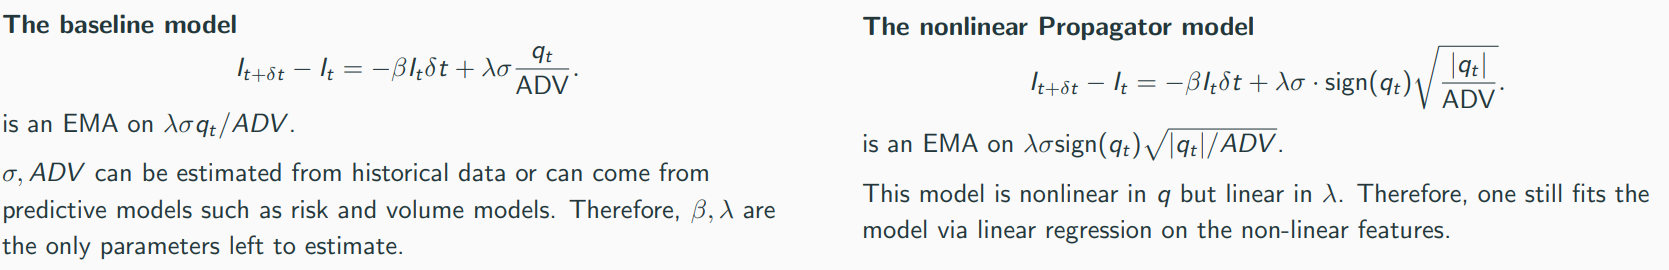

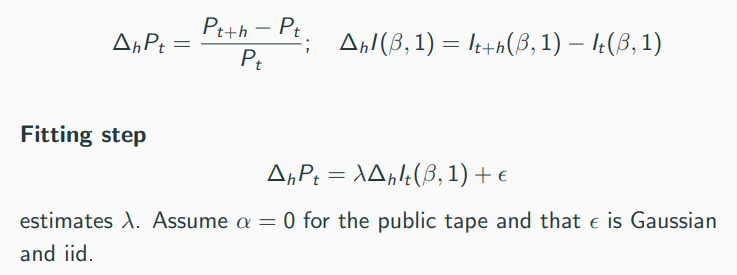

## Estimating the Impact coef $\lambda$ using $R^2$ distribution 

In [18]:
half_lifes = [60,600,1200,DEFAULT_HALF_LIFE]
explanation_periods = [2,6,DEFAULT_EXPLANATION_PERIOD,120,360] 
in_sample_month = DEFAULT_IN_SAMPLE_MONTH

index_regression_compute = 1
for half_life in half_lifes:
    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="linear") #optionnal
    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="sqrt") #optionnal
    for explanation_period in explanation_periods:
        price_impact_model.regression_by_model(half_life=half_life,model_type="linear",explanation_period=explanation_period,in_sample_month=in_sample_month)
        price_impact_model.regression_by_model(half_life=half_life,model_type="sqrt",explanation_period=explanation_period,in_sample_month=in_sample_month)
        print(f"Computing {index_regression_compute} out of {len(half_lifes)*len(explanation_periods)} regressions ...",end="\r")
        index_regression_compute+=1

'\nhalf_lifes = [60,600,1200,DEFAULT_HALF_LIFE]\nexplanation_periods = [2,6,DEFAULT_EXPLANATION_PERIOD,120,360] \nin_sample_month = DEFAULT_IN_SAMPLE_MONTH\n\nindex_regression_compute = 1\nfor half_life in half_lifes:\n    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="linear") #optionnal\n    # price_impact_model.compute_and_store_impact(half_life=half_life,model_type="sqrt") #optionnal\n    for explanation_period in explanation_periods:\n        price_impact_model.regression_by_model(half_life=half_life,model_type="linear",explanation_period=explanation_period,in_sample_month=in_sample_month)\n        price_impact_model.regression_by_model(half_life=half_life,model_type="sqrt",explanation_period=explanation_period,in_sample_month=in_sample_month)\n        print(f"Computing {index_regression_compute} out of {len(half_lifes)*len(explanation_periods)} regressions ...",end="\r")\n        index_regression_compute+=1\n'

In [19]:
price_impact_model.get_regression_result_by_key(("sqrt",DEFAULT_HALF_LIFE,DEFAULT_EXPLANATION_PERIOD,DEFAULT_IN_SAMPLE_MONTH)).head(5)

In [20]:
height_ratios = [1.] * len(half_lifes) +  [0.3]
width_ratios = [1.] * len(explanation_periods) + [0.3]

fig,axs = plt.subplots(len(half_lifes)+1,len(explanation_periods)+1,figsize=(len(explanation_periods)*3 + 2,len(half_lifes)*3 + 2),gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
color_model = {"linear":"red","sqrt":"green"}
for hf_index,half_life in enumerate(half_lifes):
    for ep_index,explanation_period in enumerate(explanation_periods):
        ax = axs[hf_index][ep_index]
        price_impact_model.get_regression_result_by_key(("linear",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("linear"),label="Baseline")
        price_impact_model.get_regression_result_by_key(("sqrt",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("sqrt"),label = "Non-linear")
        # ax.set_title(f"{half_life} / {explanation_period}")
        ax.legend()
        ax.set_xlim(-0.2, 0.75)

for hf_index,half_life in enumerate(half_lifes):
    ax = axs[hf_index][-1]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(0, 1)
    ax.text( 0.1, 0.5, half_life,fontsize = 25, va='center', transform=ax.transAxes,rotation=270)
    ax.set_facecolor("#D3D3D3")
    for spine in ax.spines.values():
        spine.set_visible(False)
for ep_index,explanation_period in enumerate(explanation_periods):
    ax = axs[-1][ep_index]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0.5, 0.4, explanation_period*10, fontsize = 25,ha='center')
    ax.set_facecolor("#D3D3D3")
    for spine in ax.spines.values():
        spine.set_visible(False)
ax = axs[-1][-1]
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
# fig.suptitle(t="$R^2$ Distribution amongst stocks for different \nhalf-life (rows) and explanation periods (colomns) ",fontsize = 35)
plt.tight_layout()
plt.show()

'\nheight_ratios = [1.] * len(half_lifes) +  [0.3]\nwidth_ratios = [1.] * len(explanation_periods) + [0.3]\n\nfig,axs = plt.subplots(len(half_lifes)+1,len(explanation_periods)+1,figsize=(len(explanation_periods)*3 + 2,len(half_lifes)*3 + 2),gridspec_kw={\'width_ratios\': width_ratios, \'height_ratios\': height_ratios})\ncolor_model = {"linear":"red","sqrt":"green"}\nfor hf_index,half_life in enumerate(half_lifes):\n    for ep_index,explanation_period in enumerate(explanation_periods):\n        ax = axs[hf_index][ep_index]\n        price_impact_model.get_regression_result_by_key(("linear",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("linear"),label="Baseline")\n        price_impact_model.get_regression_result_by_key(("sqrt",half_life,explanation_period,in_sample_month))["is_rsq"].plot.kde(ax=ax,color =color_model.get("sqrt"),label = "Non-linear")\n        # ax.set_title(f"{half_life} / {explanation_period}")\n        ax.legend()\n       

## Statistical significance of the impact coef $\lambda$

In [21]:
max_month = price_impact_model.get_bin_traded_px().index.get_level_values(level = 1).max().month
df_regression_coefficient_stat_significance = pd.DataFrame(index = price_impact_model.get_bin_traded_px().index.get_level_values(level = 0).unique())
for is_month in range(1,max_month):
    for oos_month in range(is_month+1,max_month):
        reg_result = price_impact_model.regression_by_model(half_life=DEFAULT_HALF_LIFE,model_type="sqrt",explanation_period=DEFAULT_EXPLANATION_PERIOD,in_sample_month=is_month,out_of_sample_month = oos_month)
        col_name = f"is_{is_month}__os_{oos_month}"
        df_regression_coefficient_stat_significance[col_name] = reg_result["beta_estimate"].copy()

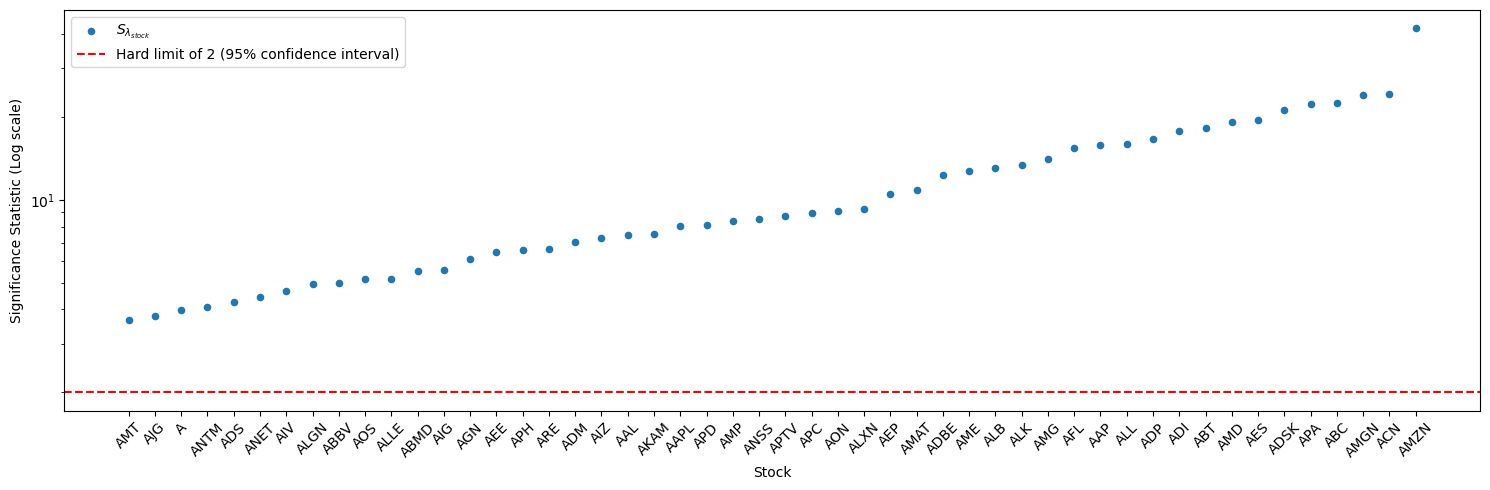

In [22]:
fig,ax = plt.subplots(1,1,figsize = (15,5))
ax.grid(False)
s_stat_df = (df_regression_coefficient_stat_significance.mean(axis=1) / df_regression_coefficient_stat_significance.std(axis=1)).reset_index()
s_stat_df = s_stat_df.rename(columns={0:'Significance Statistic (Log scale)','stock':'Stock'})
s_stat_df = s_stat_df.sort_values(by="Significance Statistic (Log scale)")
s_stat_df.plot.scatter(x="Stock",y="Significance Statistic (Log scale)",ax=ax,grid=False,label="$S_{\lambda_{stock}}$").axhline(y=2,color="red",linestyle="dashed",linewidth = 1.5,label='Hard limit of 2 (95% confidence interval)')
plt.xticks(rotation=45)
plt.yscale("log")
ax.legend()
plt.tight_layout()
plt.show()

# Remove the price impact & Backtesting strategies

## Impact-less price

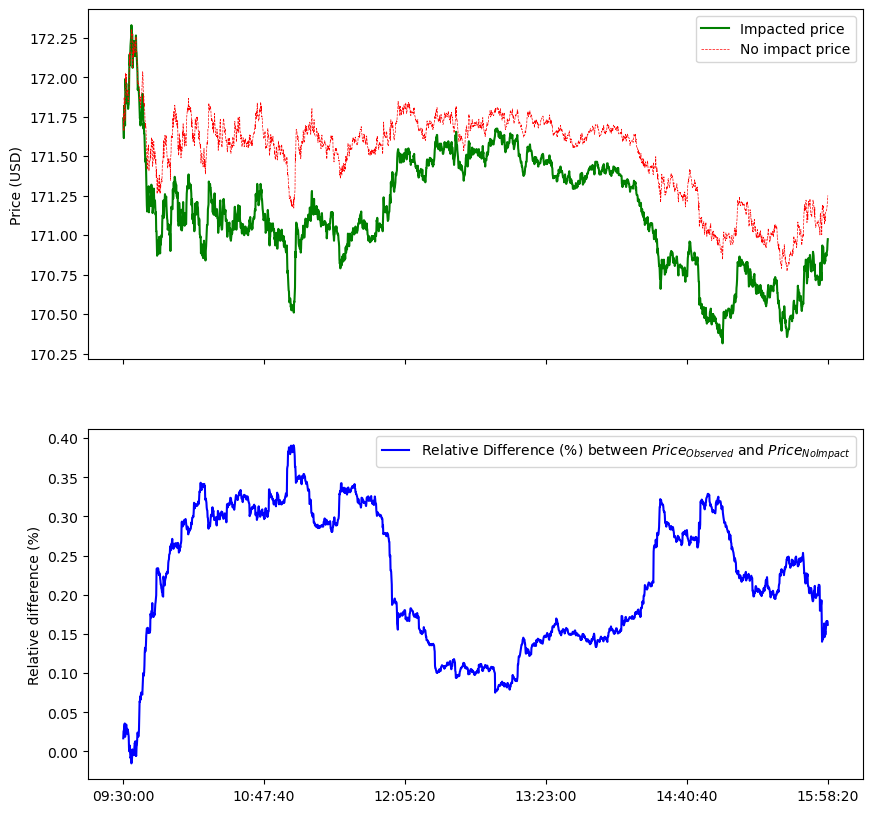

In [121]:
date = "2019-02-21"
stock = "AAPL"
price_no_impact = price_impact_model.get_no_impact_prices_df(half_life=DEFAULT_HALF_LIFE,model_type = "linear")

price_no_impact_values = price_no_impact.loc[stock].loc[date]
historical_price = price_impact_model.get_bin_traded_px().loc[stock].loc[date]

fig,axs = plt.subplots(2,1,figsize = (10,10),sharex=True)
x_values = price_no_impact.columns
ax = axs[0]
ax.plot(x_values[:-10],historical_price[:-10],color = "green",label="Impacted price")
ax.plot(x_values[:-10],price_no_impact_values[:-10],color = "red",label="No impact price",linestyle = "dashed",linewidth = 0.5)
ax.set_ylabel("Price (USD)")
ax.legend()
ax = axs[1]
ax.plot(x_values[:-10],((price_no_impact_values - historical_price) / historical_price)[:-10] * 100,color = "blue",label="Relative Difference (%) between $Price_{Observed}$ and $Price_{No Impact}$")
step = len(ax.get_xticks()) // 5
ax.set_xticks(ax.get_xticks()[::step])
ax.set_ylabel("Relative difference (%)")
ax.legend()
# fig.suptitle(f"\nPrice of {stock} on {date} with and without impact from trades",fontsize = 18)
plt.show()

## Backtesting dummy strategies

To backtest a strategy of trades (at interval of 10 seconds) for a given stock - date pair : <br>
    - Compute the impact-free price from historical data<br>
    - Compute the impact of the trading strategy on the impact-free price<br>
    - Add the impact of the trading strategy to the impact-free price<br>
    - Compare the performance of the observe price against the performance of the trading strategie<br>

Target order notional is : 31238649 USD


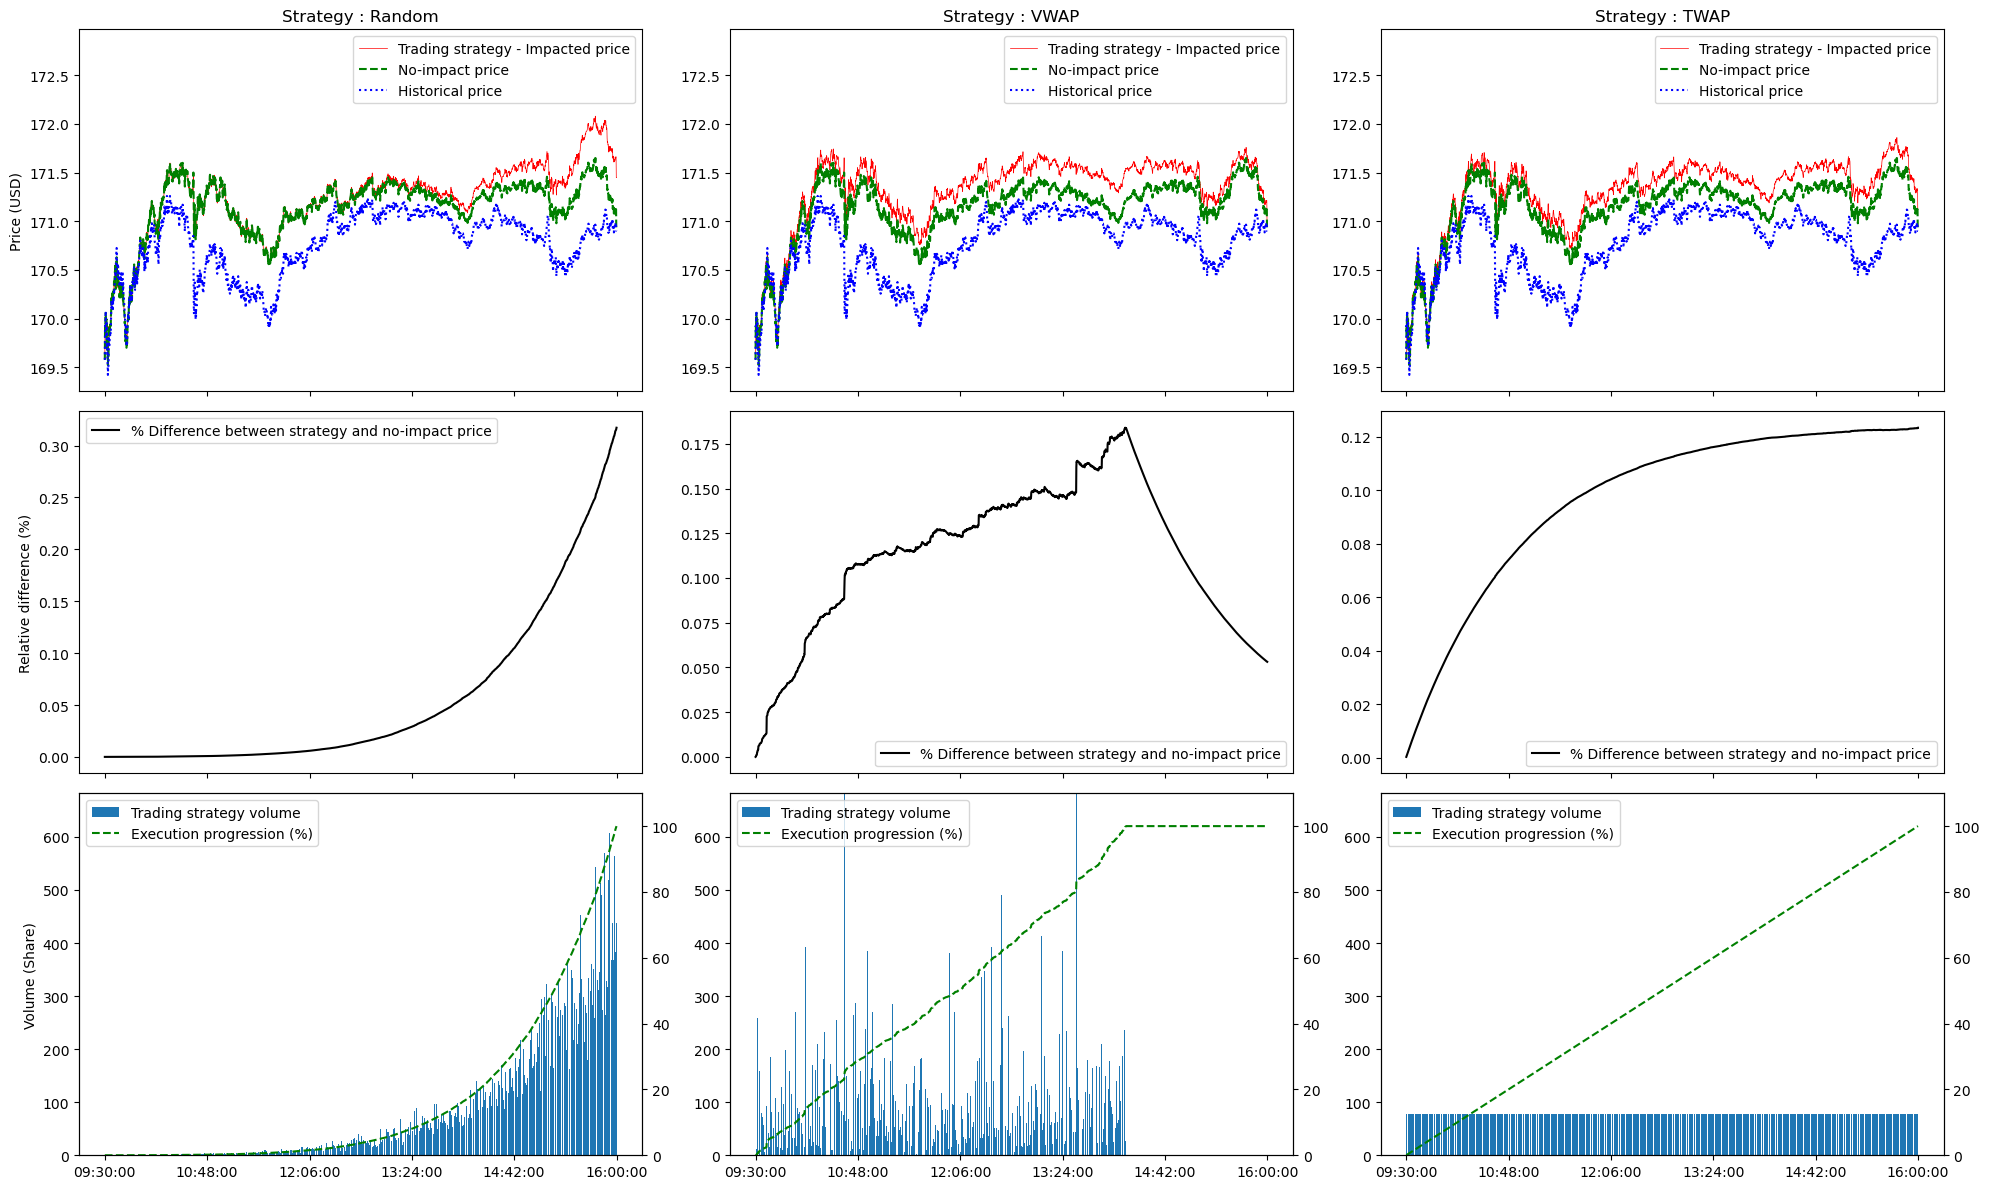

In [123]:
stock = "AAPL"
date = "2019-02-14"
execution_factor = 0.1 # 1% of total volume
model_type = "linear"

# trading_strategy = bin_traded_volume.loc[stock].loc[date].values * 100. # we trade all trades with 10% of the volume
historical_price = price_impact_model.get_bin_traded_px().loc[stock].loc[date]
historical_volume = price_impact_model.get_bin_traded_volume().loc[stock].loc[date]
target_volume = historical_volume.abs().sum() * execution_factor
no_impact_price = price_impact_model.get_no_impact_prices_df(half_life=DEFAULT_HALF_LIFE,model_type=model_type).loc[stock].loc[date]

print(f"Target order notional is : {target_volume * historical_price[0]:.0f} USD")

volume_curve = price_impact_model.get_volume_curve_from_data()
# random_trading_strategy = np.random.normal(loc = 0.2,scale = 1,size=historical_price.size)
random_trading_strategy = np.array(range(len(historical_price)))/len(historical_price) + np.random.normal(loc = 0,scale = 100/len(historical_price),size=historical_price.size)
random_trading_strategy = np.exp(10 * np.sqrt(np.abs(random_trading_strategy)))
random_trading_strategy = random_trading_strategy * target_volume / random_trading_strategy.sum()
vwap_strategy = VWAP_realistic(v = historical_volume.values, Q = target_volume, V = volume_curve.loc[stock].values)
vwap_strategy = vwap_strategy.astype(np.float64)
twap_strategy = TWAP(v = historical_price, Q = target_volume)

random_strategy_price = price_impact_model.backtest_strategies(stock = stock,date = date,trades = random_trading_strategy,half_life=DEFAULT_HALF_LIFE,model_type=model_type)
vwap_strategy_price = price_impact_model.backtest_strategies(stock = stock,date = date,trades = vwap_strategy,half_life=DEFAULT_HALF_LIFE,model_type=model_type)
twap_strategy_price = price_impact_model.backtest_strategies(stock = stock,date = date,trades = twap_strategy,half_life=DEFAULT_HALF_LIFE,model_type=model_type)

strategies = [(random_strategy_price,random_trading_strategy,"Random"),(vwap_strategy_price,vwap_strategy,"VWAP"),(twap_strategy_price,twap_strategy,"TWAP")]

fig,axs = plt.subplots(3,3,figsize = (20,12),sharex=True)
x_values = historical_price.index

for index_strat,(strat_price,strat_volume,strat_name) in enumerate(strategies):
    ax = axs[0][index_strat]
    ax.plot(x_values,strat_price,color = "red",label="Trading strategy - Impacted price",linewidth = 0.5)
    ax.plot(x_values,no_impact_price,color = "green",label="No-impact price",linestyle="dashed")
    ax.plot(x_values,historical_price,color = "blue",label="Historical price", linestyle=":")
    ax.set_title(f"Strategy : {strat_name}")
    ax.legend()
    ax.set_ylim((historical_price.min()*0.999,historical_price.max()*1.01))
    if index_strat==0:
        ax.set_ylabel("Price (USD)")
    step = len(ax.get_xticks()) // 5
    ax.set_xticks(ax.get_xticks()[::step])
    ax = axs[1][index_strat]
    if index_strat==0:
        ax.set_ylabel("Relative difference (%)")
    ax.plot(x_values,(strat_price-no_impact_price)/no_impact_price * 100,label= "% Difference between strategy and no-impact price",color ="black")
    ax.legend()
    ax = axs[2][index_strat]
    ax_percent = ax.twinx()
    if index_strat==0:
        ax.set_ylabel("Volume (Share)")
    ax.bar(x_values,strat_volume,label="Trading strategy volume")
    ax_percent.plot(x_values,np.cumsum(strat_volume)/target_volume * 100,label='Execution progression (%)',linestyle="dashed",color="green")
    ax.set_ylim((0,target_volume / 360/7.5 * 10))
    ax_percent.set_ylim((0,110))
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_percent.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper left")
plt.tight_layout()
plt.show()

# Synthetic Alphas

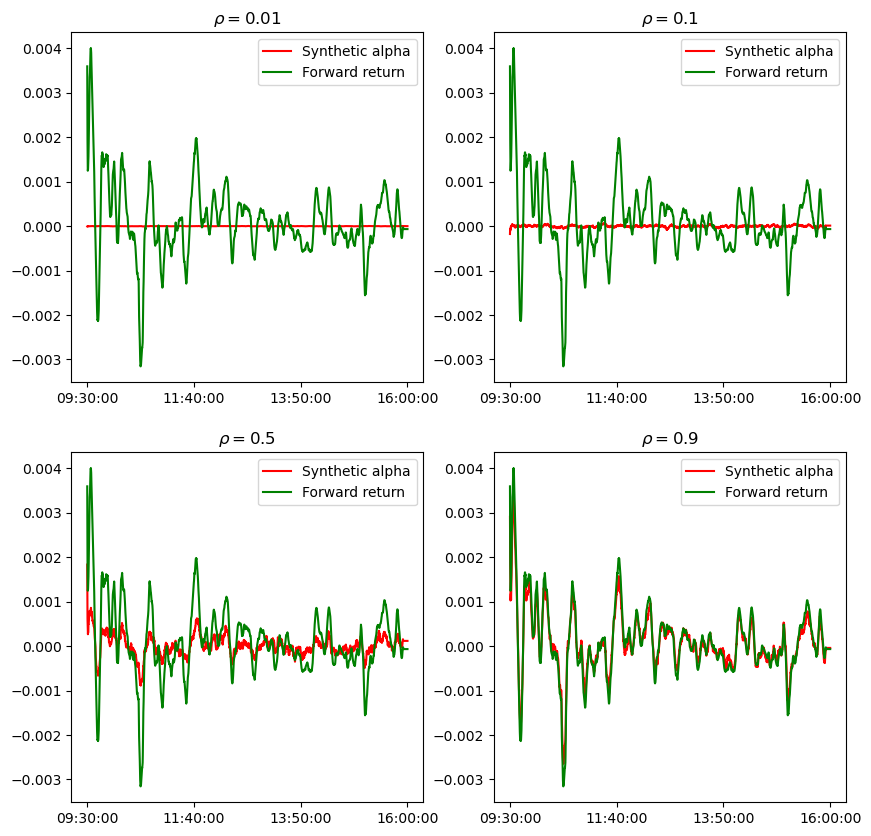

In [25]:
date = "2019-02-14"
stock = "AAPL"

rhos = [.01,.1,.5,.9]
h = 6 * 5 # 5 minutes
w = 6 * 5 # 5 minutes

fig,axs = plt.subplots(2,2,figsize=(10,10))

for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        rho = rhos[row * 2 + col]
        synth_alpha = price_impact_model.synthetic_alpha(h=h,rho = rho).loc[stock].loc[date]
        forward_return = price_impact_model.get_forward_return(prices = price_impact_model.get_bin_traded_px(),h = h).loc[stock].loc[date]
        synth_alpha = pd.Series(synth_alpha).ewm(span = w,adjust=True).mean().dropna()
        forward_return = pd.Series(forward_return).ewm(span = w,adjust=True).mean().dropna()
        ax.set_title(r"$\rho=$"+str(rho))
        ax.plot(synth_alpha,color="red",label = r"Synthetic alpha")
        ax.plot(forward_return,color="green",label=f"Forward return")
        step = len(ax.get_xticks()) // 3
        ax.set_xticks(ax.get_xticks()[::step])
        ax.legend()
plt.show()

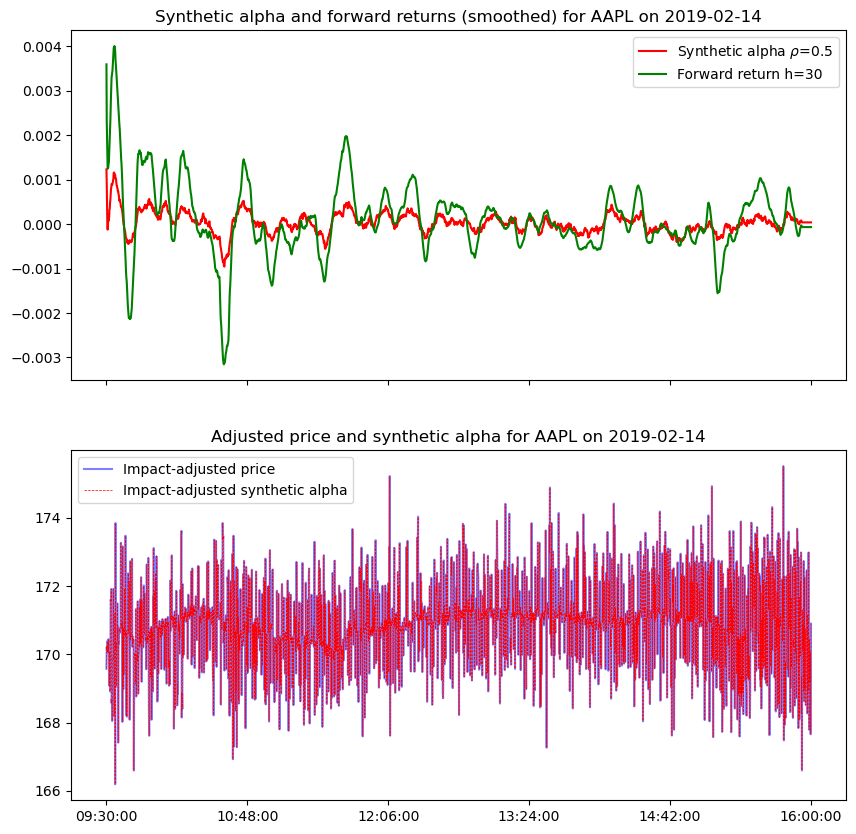

In [26]:
date = "2019-02-14"
stock = "AAPL"

rho = .5
h = 6 * 5 # 5 minutes
w = 6 * 5 # 5 minutes

synth_alpha = price_impact_model.synthetic_alpha(h=h,rho = rho).loc[stock].loc[date]
forward_return = price_impact_model.get_forward_return(prices = price_impact_model.get_bin_traded_px(),h = h).loc[stock].loc[date]

impact_adjusted_prices = price_impact_model.get_no_impact_prices_df(half_life=DEFAULT_HALF_LIFE,model_type="sqrt").loc[stock].loc[date]
synth_adjusted_alpha = impact_adjusted_prices + price_impact_model.impact_adjusted_alpha(half_life=DEFAULT_HALF_LIFE,model_type="sqrt",h = h,rho = rho).loc[stock].loc[date]

fig,axs = plt.subplots(2,1,figsize = (10,10),sharex=True)

ax = axs[0]
synth_alpha = pd.Series(synth_alpha).ewm(span = w,adjust=True).mean().dropna()
forward_return = pd.Series(forward_return).ewm(span = w,adjust=True).mean().dropna()

ax.plot(synth_alpha,color="red",label = r"Synthetic alpha $\rho$=" + str(rho))
ax.plot(forward_return,color="green",label=f"Forward return h={h}")
ax.legend()

step = len(ax.get_xticks()) // 5
ax.set_xticks(ax.get_xticks()[::step])

ax.set_title(f"Synthetic alpha and forward returns (smoothed) for {stock} on {date}")

ax = axs[1]

ax.plot(impact_adjusted_prices,color="blue",label="Impact-adjusted price",alpha =.5)
ax.plot(synth_adjusted_alpha,color = "red",linestyle="dashed", label="Impact-adjusted synthetic alpha",linewidth = 0.5)
ax.legend()
ax.set_title(f"Adjusted price and synthetic alpha for {stock} on {date}")
plt.show()

In [27]:
target_impact,optimal_volume_percent_ADV = price_impact_model.optimal_impact_state(h=30,half_life=DEFAULT_HALF_LIFE,model_type="linear",rho = .5,delta_T=6)

<AxesSubplot:xlabel='time'>

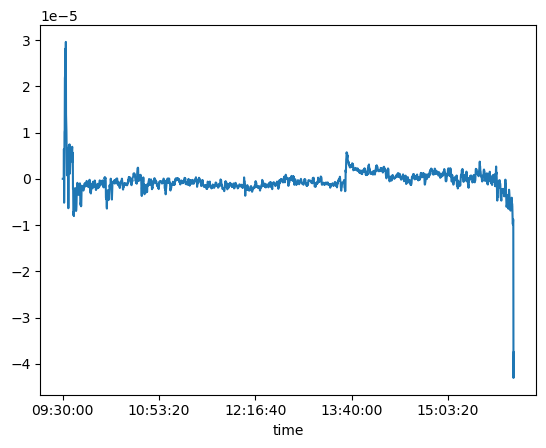

In [28]:
optimal_volume_percent_ADV.loc["AAPL"].loc["2019-02-14"].ewm(alpha=0.01).mean().plot()

<AxesSubplot:xlabel='time'>

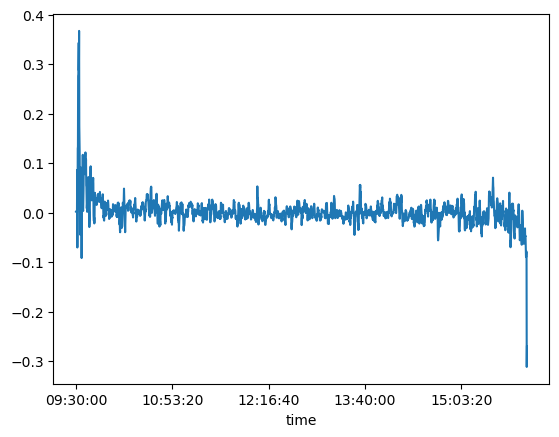

In [29]:
target_impact.loc["AAPL"].loc["2019-02-14"].ewm(alpha=.01).mean().plot()